## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [75]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import warnings

!pip install uszipcode

     |████████████████████████████████| 454 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 41 kB 3.0 MB/s eta 0:00:011
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.6.0
    Uninstalling pycodestyle-2.6.0:
      Successfully uninstalled pycodestyle-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 3.9.0 requires pyflakes<2.4.0,>=2.3.0, but you have pyflakes 2.2.0 which is incompatible.


In [ ]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [33]:
data= pd.read_csv("data/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,NaN,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [107]:
# lets clean some DTypes
#cleaning Basement Sq feet

sqft_basement_list= []
for num in data['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
data['sqft_basement']= sqft_basement_list
#cleaning year renovated        
data['yr_renovated'] = data['yr_renovated'].fillna(0).astype(int)
data['yr_renovated'] = np.where(data['yr_renovated'] == 0, data['yr_built'], data['yr_renovated'])

#corrected 33 bedroom house to 3
data['bedrooms'].replace(33, 3, inplace=True)

In [108]:
data['waterfront'].replace(np.nan, 0, inplace =True)

In [109]:
data['view'].replace(np.nan, 0 , inplace =True)

In [110]:
#check houses with same long and lat and getting rid of duplicate records

lat_long = {}
for a, b in zip(data['lat'].values, data['long'].values):
    if (a, b) not in list(lat_long.keys()):
        lat_long[(a, b)] = 1
    else:
        lat_long[(a, b)] += 1
for item in list(lat_long.keys()):
    if lat_long[item] < 2:
        del lat_long[item]
for item in list(lat_long.keys()):
        dfx = data[(data.lat == item[0]) & (data.long == item[1])]
        for id_d in dfx['id'].values:
            if dfx.loc[dfx['id'] == id_d]['yr_built'].values[0] != max(dfx['yr_built'].values):
                data = data.drop([data.loc[data['id'] == id_d].index[0]])

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21312 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21312 non-null  int64  
 1   date           21312 non-null  object 
 2   price          21312 non-null  float64
 3   bedrooms       21312 non-null  int64  
 4   bathrooms      21312 non-null  float64
 5   sqft_living    21312 non-null  int64  
 6   sqft_lot       21312 non-null  int64  
 7   floors         21312 non-null  float64
 8   waterfront     21312 non-null  float64
 9   view           21312 non-null  float64
 10  condition      21312 non-null  int64  
 11  grade          21312 non-null  int64  
 12  sqft_above     21312 non-null  int64  
 13  sqft_basement  20861 non-null  float64
 14  yr_built       21312 non-null  int64  
 15  yr_renovated   21312 non-null  int64  
 16  zipcode        21312 non-null  int64  
 17  lat            21312 non-null  float64
 18  long  

In [113]:

#Converting zipcode to city
# we are getting a look at the data per city 
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

data['City'] = data['zipcode'].apply(zip_lookup)

data["City"].value_counts()

Seattle          8792
Renton           1581
Bellevue         1396
Kent             1192
Kirkland          968
Redmond           967
Auburn            908
Sammamish         794
Federal Way       773
Issaquah          724
Maple Valley      582
Woodinville       470
Snoqualmie        307
Kenmore           280
Mercer Island     279
Enumclaw          231
North Bend        217
Bothell           195
Duvall            189
Carnation         122
Vashon            117
Black Diamond      99
Fall City          80
Medina             49
Name: City, dtype: int64

In [114]:
df_seattle = data[data['City'] == 'Seattle']

In [115]:
df_seattle.loc[df_seattle['price'].idxmin()]

id               40000362
date             5/6/2014
price            78000.00
bedrooms                2
bathrooms            1.00
sqft_living           780
sqft_lot            16344
floors               1.00
waterfront           0.00
view                 0.00
condition               1
grade                   5
sqft_above            780
sqft_basement        0.00
yr_built             1942
yr_renovated         1942
zipcode             98168
lat                 47.47
long              -122.28
sqft_living15        1700
sqft_lot15          10387
City              Seattle
Name: 15279, dtype: object

<AxesSubplot:xlabel='price', ylabel='Density'>

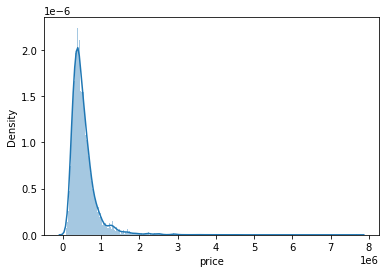

In [96]:
sns.distplot(a= df_seattle['price'], bins = 300)

In [127]:

data.loc("City")

ValueError: No axis named City for object type DataFrame

TypeError: string indices must be integers

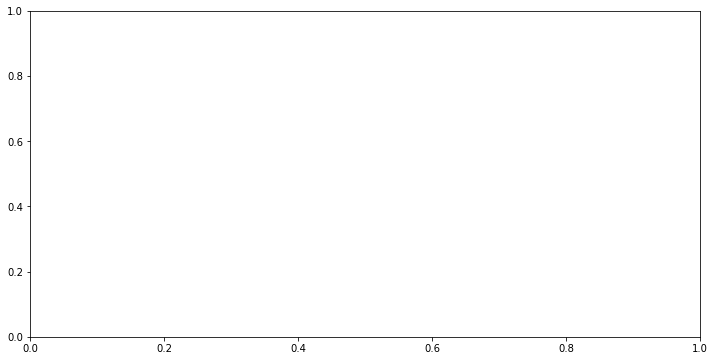

In [121]:
for city in data['City']:
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.distplot(data.groupby("City")== city ['price'], bins=50, color = 'b')
    ax.set(xlim=[0, 5000000], xlabel='Sale Price', ylabel='Sale Count',
       title='Sale Distribution')